In [1]:
import warnings
import sys
warnings.filterwarnings('ignore')
sys.path.append('../src')

# preprocess import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import weibull_min

# Patch sklearn
from sklearnex import patch_sklearn, config_context
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# Pipeline
from sklearn.pipeline import Pipeline

# custom functions
import config
from utils import DataConnector
from metric import NMAE
from data_processor import *

# model import
import lightgbm as lgb
from lightgbm import LGBMRegressor

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# 1. Define Functions

### Not Used in Final

In [3]:
# not used in final
# def power_curve_fit_(speed, density):
#    temp_speed = np.where(speed < 2.5, 0,
#                         np.where(speed >= 20, 0, speed))

#    ideal_energy = (speed ** 3)*density*0.5*(56**2)*np.pi/1000

#    power_max = 2300

#    curve_fitted = np.where(ideal_energy >= power_max, power_max, ideal_energy)
   
#    curve_fitted = ideal_energy
#    return curve_fitted

# def create_deviation_within_month(df, num_features):
#     result = pd.DataFrame()
#     for f in num_features:
#         feature = df.columns[df.columns.str.contains(f)]
#         grouped_median = df.groupby(df['dt'].dt.month)[feature].transform('mean')
#         deviation_col_name = 'month_deviation_from_mean_' + feature
#         new_columns = df[feature] - grouped_median
#         new_columns.columns = deviation_col_name
#         result = pd.concat([result, new_columns], axis=1)
#     return result

# def create_diff_features(df, num_features, windows=[1, 3]):
#     result = pd.DataFrame()
#     for f in num_features:
#         feature = df.columns[df.columns.str.contains(f)]
#         for dt in windows:
#             diff_col_name = f'diff_{dt}_' + feature
#             new_columns = df[feature].diff(dt).bfill()
#             new_columns.columns = diff_col_name
#             result = pd.concat([result, new_columns], axis=1)
#     return result

# def weibull_fit(observed, predicted):
#     # 파라미터 추정
#     shape_param, loc, scale_param = weibull_min.fit(observed, floc=0)
#     # 관측값의 CDF 계산
#     observed_cdf = weibull_min.cdf(observed, shape_param, loc, scale_param)
#     # 예측값의 CDF 계산
#     predicted_cdf = weibull_min.cdf(predicted, shape_param, loc, scale_param)
#     # 예측값을 보정하기 위해, 관측값의 분포를 사용하여 보정된 값을 계산
#     adjusted_values = weibull_min.ppf(predicted_cdf, shape_param, loc, scale_param)
#     return adjusted_values

### Final Functions  
-- preprocess

In [4]:
def pivot_data(data, index, columns, values, reset_index=True, reset_columns=True):

    result = (data
              .pivot(index=index,
                     columns=columns,
                     values=values)
              .reset_index())
    
    if reset_columns:
       result.columns =[' '.join(col).strip() for col in result.columns.values]

    return result

# hour ensemble mean
def create_deviation_within_hours(df, num_features):
    result = pd.DataFrame()
    for f in num_features:
        feature = df.columns[df.columns.str.contains(f)]
        grouped_median = df.groupby(df['dt'].dt.hour)[feature].transform('mean')
        deviation_col_name = 'deviation_from_mean_' + feature
        new_columns = df[feature] - grouped_median
        new_columns.columns = deviation_col_name
        result = pd.concat([result, new_columns], axis=1)
    return result

def create_deviation_within_night(df, num_features):
    result = pd.DataFrame()
    for f in num_features:
        feature = df.columns[df.columns.str.contains(f)]
        grouped_median = df.groupby('Night')[feature].transform('mean')
        deviation_col_name = 'night_deviation_from_mean_' + feature
        new_columns = df[feature] - grouped_median
        new_columns.columns = deviation_col_name
        result = pd.concat([result, new_columns], axis=1)
    return result

def create_global_features(df, num_features):
    result = pd.DataFrame()
    for f in num_features:
        feature = df.columns[df.columns.str.contains(f)]
        result[f'{f} mean'] = df[feature].mean(axis=1)
        result[f'{f} std'] = df[feature].std(axis=1)
        result[f'{f} median'] = df[feature].median(axis=1)
    return result

def Wind2Vec(ws, wd):
    
    u = ws * np.cos(np.deg2rad(wd))
    v = ws * np.sin(np.deg2rad(wd))

    return u, v

def wtg_gauss_mean(scada, values='Energy Production\nActive Energy Production\n[KWh]'):
    active_energy = scada.pivot(index='dt',
                                columns='turbine_id', 
                                values=values)

    std, mean = active_energy.std(), active_energy.mean()  

    gauss = 1/(std * np.sqrt(2 * np.pi))*np.exp(-0.5 * np.square((active_energy-mean) / (std + 1e-8)) + 1e-8)  
  
    gauss_mean = np.sum(gauss * active_energy)/np.sum(gauss)
    dist = gauss_mean / np.sum(gauss_mean)
    return dist

### Final Functions
-- Model Selection

In [5]:
def make_train_test(pivot_df, train_y, test_size=0.2):
    dataset = pd.merge(pivot_df, train_y[['dt', 'energy_kwh']],
                   how='left',
                   on='dt')
    size = dataset.shape[0]
    threshold = int(size * (1 - test_size))
    train = dataset.iloc[:threshold, :]
    test = dataset.iloc[threshold:]

    x_train, y_train = train.drop(['dt', 'energy_kwh'], axis=1), train['energy_kwh']
    x_test, y_test = test.drop(['dt', 'energy_kwh'], axis=1), test['energy_kwh']

    gc.collect();
    return dataset, x_train, x_test, y_train, y_test

-- Metrics

In [6]:
def build_metrics(true, pred, capacity):
    result = pd.DataFrame()

    result['energy_kwh'] = true
    result['pred_energy_kwh'] = pred
    result['capacity'] = capacity

    result["normalized_abs_error"] = abs(result.pred_energy_kwh-result.energy_kwh)/result.capacity*100
    result['incentive'] = 0.
    result.loc[(result.normalized_abs_error > 6) & (result.normalized_abs_error <= 8), 'incentive'] = 3.
    result.loc[(result.normalized_abs_error <= 6), 'incentive'] = 4.
    result.loc[result.energy_kwh < result.capacity*0.1, 'incentive'] = 0.

    nmae = round(result.normalized_abs_error.mean(), 2)
    total_incentive = np.floor((result.incentive * true).sum())
    available_max_incentive = np.floor((4*true[true>=result.capacity*0.1])).sum()


    print("NMAE =", nmae, "%")
    print("예측정산금획득율 =", round(total_incentive/available_max_incentive*100, 2), "%")
    print("예측제도정산금 =", int(total_incentive), "원")
    return round(total_incentive/available_max_incentive*100, 2)

# 2. Load Scada

-- YG

In [7]:
scada_yg = pd.DataFrame()
for turbine_idx in range(1, 36):
    tmp = (pd.read_parquet(config.input_path + f"ewp004_2020_2022_WTG{turbine_idx}.parquet")
             .rename(columns = {'Date/Time': 'dt', 'WTG.Name': 'turbine_id', 'WTG. Name': 'turbine_id'}))
    scada_yg = pd.concat([scada_yg, tmp], axis=0)

idx = scada_yg.loc[scada_yg['dt'].isin(['Summation', 'Average', 'Standard Deviation'])].index
scada_yg.drop(idx, axis=0, inplace=True)

try:
    scada_yg['dt'] = (pd.to_datetime(scada_yg['dt'])
                      .dt
                      .tz_convert("Asia/Seoul"))

except TypeError:
    scada_yg['dt'] = (pd.to_datetime(scada_yg['dt'])
                      .dt
                      .tz_localize("Asia/Seoul"))
    
gc.collect();

-- GJ

In [8]:
scada_gj = pd.DataFrame()
for turbine_idx in range(1, 10):
    tmp = (pd.read_parquet(config.input_path + f"ewp02_2020_2022_WTG{turbine_idx}.parquet")
             .rename(columns = {'Date/Time': 'dt', 'WTG.Name': 'turbine_id', 'WTG. Name': 'turbine_id'}))
    scada_gj = pd.concat([scada_gj, tmp], axis=0)

idx = scada_gj.loc[scada_gj['dt'].isin(['Summation', 'Average', 'Standard Deviation'])].index
scada_gj.drop(idx, axis=0, inplace=True)

try:
    scada_gj['dt'] = (pd.to_datetime(scada_gj['dt'])
                      .dt
                      .tz_convert("Asia/Seoul"))
    
except TypeError:
    scada_gj['dt'] = (pd.to_datetime(scada_gj['dt'])
                      .dt
                      .tz_localize("Asia/Seoul"))
    
gc.collect();

# 3. Preprocessing

### 1st process  
-- YG

In [9]:
train_y_yg, ldaps_yg = DataConnector().get_data(start_date='2020-01-01',
                                                end_date='2023-01-01',
                                                plant_name='영광풍력')

# build data pipeline
print('-' * 50)
print('Feature Engineering')

DataPipeline = Pipeline([
    ('uv_transform', UVTransformer('wind_u_10m', 'wind_v_10m')),
    ('wind_transform', WindTransformer('wind_speed', 10, ldaps_yg['elevation'] + 100, ldaps_yg['surf_rough'])),
    ('feature_engineering', FeatureTransformer()),
])

# data transform
ldaps_yg = DataPipeline.fit_transform(ldaps_yg)
gc.collect();

print('Done')
print('-' * 50)

--------------------------------------------------
Feature Engineering
Done
--------------------------------------------------


-- GJ

In [10]:
train_y_gj, ldaps_gj = DataConnector().get_data(start_date='2020-01-01',
                                                end_date='2023-01-01',
                                                plant_name='경주풍력')

# build data pipeline
print('-' * 50)
print('Feature Engineering')

DataPipeline = Pipeline([
    ('uv_transform', UVTransformer('wind_u_10m', 'wind_v_10m')),
    ('wind_transform', WindTransformer('wind_speed', 10, ldaps_gj['elevation'] + 100, ldaps_gj['surf_rough'])),
    ('feature_engineering', FeatureTransformer()),
])

# data transform
ldaps_gj = DataPipeline.fit_transform(ldaps_gj)
gc.collect();

print('Done')
print('-' * 50)

--------------------------------------------------
Feature Engineering
Done
--------------------------------------------------


### 2nd process

In [11]:
wind_dist_gj = 1 - wtg_gauss_mean(scada_gj, 'Nacelle\nWind Speed\n[m/s]')
wind_dist_yg = 1 - wtg_gauss_mean(scada_yg, 'Nacelle\nWind Speed\n[m/s]')

temp_dist_gj = 1 - wtg_gauss_mean(scada_gj, 'Nacelle\nOutdoor Temp\n[℃]')
temp_dist_yg = 1 - wtg_gauss_mean(scada_yg, 'Nacelle\nOutdoor Temp\n[℃]')

density_dist_gj = 1 - wtg_gauss_mean(scada_gj, 'Nacelle\nAir Density\n[kg/㎥]')
density_dist_yg = 1 - wtg_gauss_mean(scada_yg, 'Nacelle\nAir Density\n[kg/㎥]')

In [12]:
ldaps_yg['wind_u_100m'], ldaps_yg['wind_v_100m'] = Wind2Vec(ldaps_yg['wind_speed_100m'], ldaps_yg['wind_direction'])
ldaps_gj['wind_u_100m'], ldaps_gj['wind_v_100m'] = Wind2Vec(ldaps_gj['wind_speed_100m'], ldaps_gj['wind_direction'])

ldaps_yg['wind_intensity'] = np.sqrt(ldaps_yg['wind_u_100m'] ** 2 + ldaps_yg['wind_v_100m'] ** 2)
ldaps_gj['wind_intensity'] = np.sqrt(ldaps_gj['wind_u_100m'] ** 2 + ldaps_gj['wind_v_100m'] ** 2)

In [13]:
transform_features = ['wind_u_100m', 'wind_v_100m', 'wind_intensity', 'wind_speed_100m',\
'density', 'temp_air', 'relative_humid', 'specific_humid', 'frictional_vmax_50m', 'frictional_vmin_50m']

dist_features = ['wind_speed_100m', 'temp_air', 'density']

dist_value_gj = [wind_dist_gj, temp_dist_gj, density_dist_gj]
dist_value_yg = [wind_dist_yg, temp_dist_yg, density_dist_yg]

## 경주풍력
temp = ldaps_gj[['turbine_id', 'dt', *transform_features]].copy()

# Pivot
ldaps_pivot_gj = pivot_data(temp, 'dt', 'turbine_id', transform_features,
                            reset_columns=True)

# Dot weights
for f, v in zip(dist_features, dist_value_gj):
    feature = ldaps_pivot_gj.columns[ldaps_pivot_gj.columns.str.contains(f)]
    ldaps_pivot_gj[feature] *= v.values

# Datetime Transform
ldaps_pivot_gj = DatetimeTransformer('gj', encoding=False).fit_transform(ldaps_pivot_gj).drop(['day', 'year'], axis=1)
ldaps_pivot_gj['cos_hour'], ldaps_pivot_gj['sin_hour'] = np.cos(2 * np.pi * ldaps_pivot_gj['hour']/24), np.sin(ldaps_pivot_gj['hour']/24)
ldaps_pivot_gj[f'cos_month'], ldaps_pivot_gj[f'sin_month'] = np.cos(ldaps_pivot_gj['month']/12), np.sin(ldaps_pivot_gj['month']/12)
ldaps_pivot_gj.drop(['hour', 'month'], axis=1, inplace=True)

# deviation, global
gj_pivot_global = create_global_features(ldaps_pivot_gj, transform_features)
gj_pivot_dev = create_deviation_within_hours(ldaps_pivot_gj, transform_features)
gj_pivot_dev_n = create_deviation_within_night(ldaps_pivot_gj, transform_features)

ldaps_pivot_gj = pd.concat([ldaps_pivot_gj, gj_pivot_global, gj_pivot_dev, gj_pivot_dev_n], axis=1)

## 영광풍력
temp = ldaps_yg[['turbine_id', 'dt', *transform_features]].copy()

# Pivot
ldaps_pivot_yg = pivot_data(temp, 'dt', 'turbine_id', transform_features,
                            reset_columns=True)

# Dot weights
for f, v in zip(dist_features, dist_value_yg):
    feature = ldaps_pivot_yg.columns[ldaps_pivot_yg.columns.str.contains(f)]
    ldaps_pivot_yg[feature] *= v.values

# Datetime Transform
ldaps_pivot_yg = DatetimeTransformer('gj', encoding=False).fit_transform(ldaps_pivot_yg).drop(['day', 'year'], axis=1)
ldaps_pivot_yg['cos_hour'], ldaps_pivot_yg['sin_hour'] = np.cos(2 * np.pi * ldaps_pivot_yg['hour']/24), np.sin(ldaps_pivot_yg['hour']/24)
ldaps_pivot_yg[f'cos_month'], ldaps_pivot_yg[f'sin_month'] = np.cos(ldaps_pivot_yg['month']/12), np.sin(ldaps_pivot_yg['month']/12)
ldaps_pivot_yg.drop(['hour', 'month'], axis=1, inplace=True)

# deviation, global
yg_pivot_global = create_global_features(ldaps_pivot_yg, transform_features)
yg_pivot_dev = create_deviation_within_hours(ldaps_pivot_yg, transform_features)
yg_pivot_dev_n = create_deviation_within_night(ldaps_pivot_yg, transform_features)

ldaps_pivot_yg = pd.concat([ldaps_pivot_yg, yg_pivot_global, yg_pivot_dev, yg_pivot_dev_n], axis=1)

print(ldaps_pivot_gj.shape, ldaps_pivot_yg.shape)
gc.collect();

(26202, 307) (26202, 1087)


# 4. Model Train

-- GJ

In [14]:
import config
import joblib

final = True

if not final:
    X = ldaps_pivot_gj
    y = train_y_gj

    capacity = 20700

    _, x_train, x_test, y_train, y_test = make_train_test(X, y, test_size=0.2)

    # zero mean
    y_mean = y_train.mean()
    y_train -= y_mean

    model_gj = LGBMRegressor(**config.lgb_params['gj'])

    # train
    model_gj.fit(x_train, y_train)

    # predict
    y_pred = model_gj.predict(x_test)
    y_pred = np.clip(y_pred + y_mean, 0, capacity)

    NMAE(y_test, y_pred, capacity)
    _ = build_metrics(y_test, y_pred, capacity)

    # for check overfit
    print(model_gj.score(x_train, y_train))
    print(model_gj.score(x_test, (y_test - y_mean)))

else:
    # for final train
    tmp = pd.merge(ldaps_pivot_gj, train_y_gj[['dt', 'energy_kwh']], 
                   how='inner', 
                   on='dt')

    X = tmp.drop(['dt', 'energy_kwh'], axis=1)
    y = tmp['energy_kwh']

    y_mean = y.mean()
    y -= y_mean

    model_gj = LGBMRegressor(**config.lgb_params['gj'])
    model_gj.fit(X, y)

    print(model_gj.score(X, y))

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 76578
[LightGBM] [Info] Number of data points in the train set: 26202, number of used features: 306
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 306 dense feature groups (7.70 MB) tra

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3


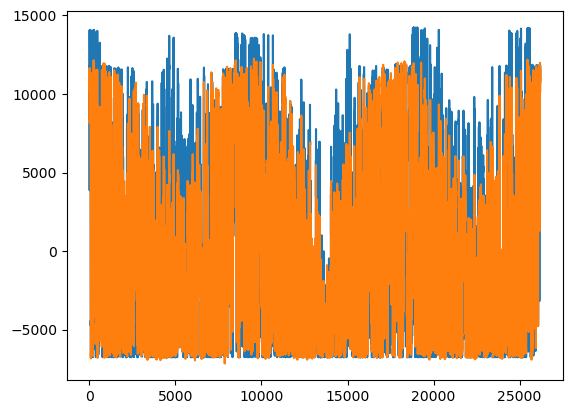

In [15]:
plt.plot(list(range(len(y))), y)
plt.plot(list(range(len(y))), model_gj.predict(X))

-- YG

In [17]:
import config
import joblib

final = True

if not final:
    X = ldaps_pivot_yg
    y = train_y_yg

    capacity = 79600

    _, x_train, x_test, y_train, y_test = make_train_test(X, y, test_size=0.2)

    # zero mean
    y_mean = y_train.mean()
    y_train -= y_mean

    model_yg = LGBMRegressor(**config.lgb_params['yg'])

    # train
    model_yg.fit(x_train, y_train)

    # predict
    y_pred = model_yg.predict(x_test)
    y_pred = np.clip(y_pred + y_mean, 0, capacity)

    NMAE(y_test, y_pred, capacity)
    _ = build_metrics(y_test, y_pred, capacity)

    # for check overfit
    print(model_yg.score(x_train, y_train))
    print(model_yg.score(x_test, (y_test - y_mean)))

else:
    # for final train
    tmp = pd.merge(ldaps_pivot_yg, train_y_yg[['dt', 'energy_kwh']], 
                   how='inner', 
                   on='dt')

    X = tmp.drop(['dt', 'energy_kwh'], axis=1)
    y = tmp['energy_kwh']

    y_mean = y.mean()
    y -= y_mean

    model_yg = LGBMRegressor(**config.lgb_params['yg'])
    model_yg.fit(X, y)

    print(model_yg.score(X, y))

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 275478
[LightGBM] [Info] Number of data points in the train set: 26202, number of used features: 1086
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 1086 dense feature groups (27.19 MB)

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3


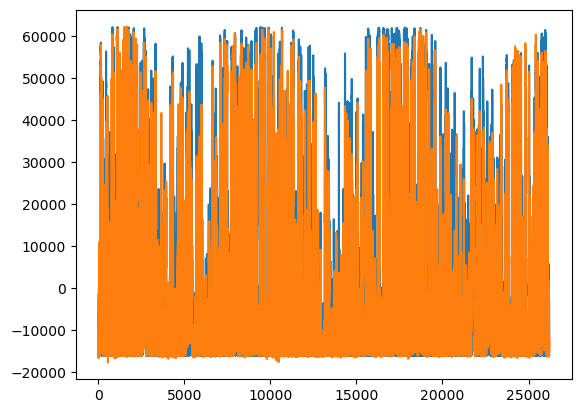

In [18]:
plt.plot(list(range(len(y))), y)
plt.plot(list(range(len(y))), model_yg.predict(X))

-- Model Save

In [19]:
# import joblib

# joblib.dump(model_yg, config.model_output + 'lgb_yg_1029_total.pkl')
# joblib.dump(model_gj, config.model_output + 'lgb_gj_1029_total.pkl')

# 5. Inference

In [20]:
submission = pd.read_csv(config.input_path + "submission_format.csv", encoding='euc-kr')
test_y_gj = pd.read_parquet(config.input_path + "test_ldaps_gyeongju.parquet")
test_y_yg = pd.read_parquet(config.input_path + "test_ldaps_yeonggwang.parquet")

# build data pipeline
print('-' * 50)
print('Feature Engineering')

DataPipeline_yg = Pipeline([
    ('uv_transform', UVTransformer('wind_u_10m', 'wind_v_10m')),
    ('wind_transform', WindTransformer('wind_speed', 10, test_y_yg['elevation'] + 100, test_y_yg['surf_rough'])),
    ('feature_engineering', FeatureTransformer())
])

DataPipeline_gj = Pipeline([
    ('uv_transform', UVTransformer('wind_u_10m', 'wind_v_10m')),
    ('wind_transform', WindTransformer('wind_speed', 10, test_y_gj['elevation'] + 100, test_y_gj['surf_rough'])),
    ('feature_engineering', FeatureTransformer())
])

# data transform
test_y_yg = DataPipeline_yg.fit_transform(test_y_yg)
gc.collect();

# data transform
test_y_gj = DataPipeline_gj.fit_transform(test_y_gj)
gc.collect();

--------------------------------------------------
Feature Engineering


In [21]:
test_y_yg['wind_u_100m'], test_y_yg['wind_v_100m'] = Wind2Vec(test_y_yg['wind_speed_100m'], test_y_yg['wind_direction'])
test_y_gj['wind_u_100m'], test_y_gj['wind_v_100m'] = Wind2Vec(test_y_gj['wind_speed_100m'], test_y_gj['wind_direction'])

test_y_yg['wind_intensity'] = np.sqrt(test_y_yg['wind_u_100m'] ** 2 + test_y_yg['wind_v_100m'] ** 2)
test_y_gj['wind_intensity'] = np.sqrt(test_y_gj['wind_u_100m'] ** 2 + test_y_gj['wind_v_100m'] ** 2)

In [22]:
transform_features = ['wind_u_100m', 'wind_v_100m', 'wind_intensity', 'wind_speed_100m',\
'density', 'temp_air', 'relative_humid', 'specific_humid', 'frictional_vmax_50m', 'frictional_vmin_50m']

dist_features = ['wind_speed_100m', 'temp_air', 'density']

## 경주풍력
temp = test_y_gj[['turbine_id', 'dt', *transform_features]].copy()

# Pivot
test_pivot_gj = pivot_data(temp, 'dt', 'turbine_id', transform_features,
                            reset_columns=True)

# Dot weights
for f, v in zip(dist_features, dist_value_gj):
    feature = test_pivot_gj.columns[test_pivot_gj.columns.str.contains(f)]
    test_pivot_gj[feature] *= v.values

# Datetime Transform
test_pivot_gj = DatetimeTransformer('gj', encoding=False).fit_transform(test_pivot_gj).drop(['day', 'year'], axis=1)
test_pivot_gj['cos_hour'], test_pivot_gj['sin_hour'] = np.cos(2 * np.pi * test_pivot_gj['hour']/24), np.sin(test_pivot_gj['hour']/24)
test_pivot_gj[f'cos_month'], test_pivot_gj[f'sin_month'] = np.cos(test_pivot_gj['month']/12), np.sin(test_pivot_gj['month']/12)
test_pivot_gj.drop(['hour', 'month'], axis=1, inplace=True)

# ensemble, global
gj_test_global = create_global_features(test_pivot_gj, transform_features)
gj_test_dev = create_deviation_within_hours(test_pivot_gj, transform_features)
gj_test_dev_n = create_deviation_within_night(test_pivot_gj, transform_features)

test_pivot_gj = pd.concat([test_pivot_gj, gj_test_global, gj_test_dev, gj_test_dev_n], axis=1)

## 영광풍력
temp = test_y_yg[['turbine_id', 'dt', *transform_features]].copy()

# Pivot
test_pivot_yg = pivot_data(temp, 'dt', 'turbine_id', transform_features,
                            reset_columns=True)

# Dot weights
for f, v in zip(dist_features, dist_value_yg):
    feature = test_pivot_yg.columns[test_pivot_yg.columns.str.contains(f)]
    test_pivot_yg[feature] *= v.values

# Datetime Transform
test_pivot_yg = DatetimeTransformer('yg', encoding=False).fit_transform(test_pivot_yg).drop(['day', 'year'], axis=1)
test_pivot_yg['cos_hour'], test_pivot_yg['sin_hour'] = np.cos(2 * np.pi * test_pivot_yg['hour']/24), np.sin(test_pivot_yg['hour']/24)
test_pivot_yg[f'cos_month'], test_pivot_yg[f'sin_month'] = np.cos(test_pivot_yg['month']/12), np.sin(test_pivot_yg['month']/12)
test_pivot_yg.drop(['hour', 'month'], axis=1, inplace=True)

# ensemble, global
yg_test_global = create_global_features(test_pivot_yg, transform_features)
yg_test_dev = create_deviation_within_hours(test_pivot_yg, transform_features)
yg_test_dev_n = create_deviation_within_night(test_pivot_yg, transform_features)

test_pivot_yg = pd.concat([test_pivot_yg, yg_test_global, yg_test_dev, yg_test_dev_n], axis=1)

print(test_pivot_gj.shape, test_pivot_yg.shape)
gc.collect();

(8760, 307) (8760, 1087)


In [23]:
import joblib

model_gj = joblib.load(config.model_output + "lgb_gj_1029_total.pkl")
model_yg = joblib.load(config.model_output + "lgb_yg_1029_total.pkl")

In [24]:
preds_yg = model_yg.predict(test_pivot_yg.drop(['dt'], axis=1)) + train_y_yg['energy_kwh'].mean()
preds_gj = model_gj.predict(test_pivot_gj.drop(['dt'], axis=1)) + train_y_gj['energy_kwh'].mean()

preds_yg = np.clip(preds_yg, 0, 79600)
preds_gj = np.clip(preds_gj, 0, 20700)

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=3, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3


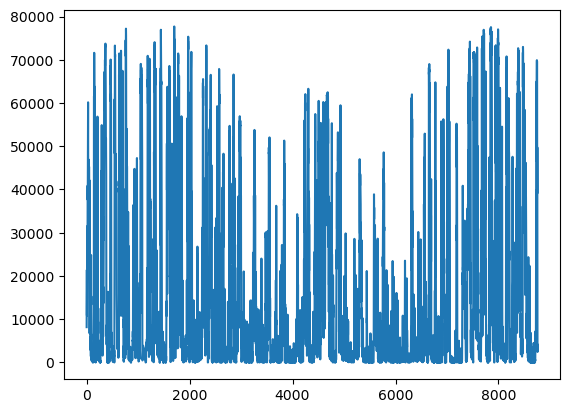

In [25]:
plt.plot(preds_yg)

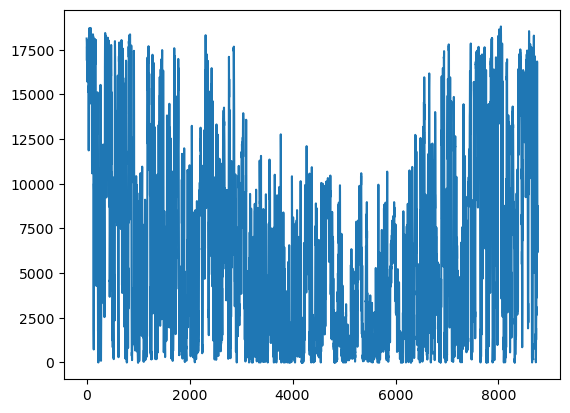

In [26]:
plt.plot(preds_gj)

In [27]:
gj = submission.loc[submission['plant_name'] == '경주풍력']
yg = submission.loc[submission['plant_name'] == '영광풍력']

In [28]:
gj['energy_kwh'] = preds_gj
yg['energy_kwh'] = preds_yg

In [29]:
final_submission = pd.concat([gj, yg], axis=0)
#final_submission.to_csv(config.input_path + "씽씽 불어라팀 5차 중간평가 제출(모델3).csv", index=False)

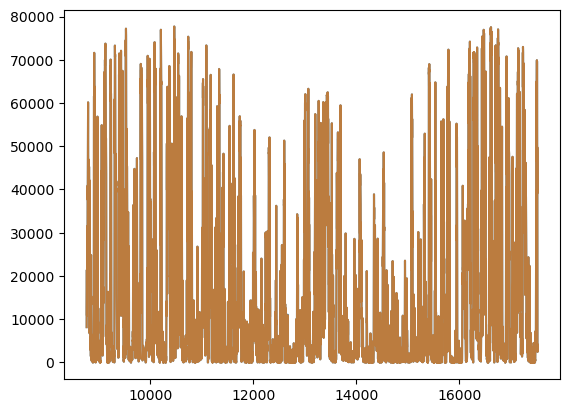

In [30]:
df = pd.read_csv(config.input_path + "씽씽 불어라팀 5차 중간평가 제출(모델3).csv")
plt.plot(final_submission.loc[final_submission['plant_name'] == '영광풍력', 'energy_kwh'])
plt.plot(df.loc[df['plant_name'] == '영광풍력', 'energy_kwh'], alpha=0.7)

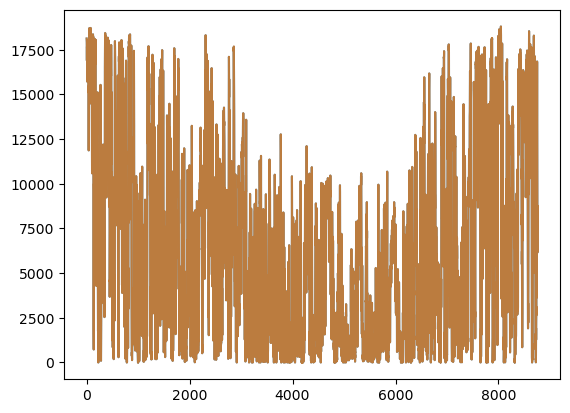

In [37]:
df = pd.read_csv(config.input_path + "씽씽 불어라팀 5차 중간평가 제출(모델3).csv")
plt.plot(final_submission.loc[final_submission['plant_name'] == '경주풍력', 'energy_kwh'])
plt.plot(df.loc[df['plant_name'] == '경주풍력', 'energy_kwh'], alpha=0.7)